In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating environment at `~/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/CDC2022-hVB-NARMAX/CDC-2022/Project.toml`


In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using ForwardDiff
using Distributions
using Plots
using LinearAlgebra
using Random
using MAT
using JLD
using Parameters
using Optim
import ProgressMeter

In [3]:
import ReactiveMP.messageout

In [4]:
include("../helpers/data.jl")

generate_data

In [5]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [6]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [7]:
data_seed, params_seed = 42, 120

(42, 120)

In [8]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [9]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(order))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [10]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                               observations_prev, controls,
                                                                               y_order, u_order, h_order,
                                                                               options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [11]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [12]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+order_u))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [13]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1000-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-1.163594971834848, 1.6980992633358802]
 [-2.955485356093763, -1.163594971834848]
 [-2.0301161338791127, -2.955485356093763]
 [0.7617324994637679, -2.0301161338791127]
 [2.8532477857090632, 0.7617324994637679]
 [2.321500216199773, 2.8532477857090632]
 [-0.3446239459368184, 2.321500216199773]
 [-2.6939024414938535, -0.3446239459368184]
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238,

In [14]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

---
### Inspect data and write to file

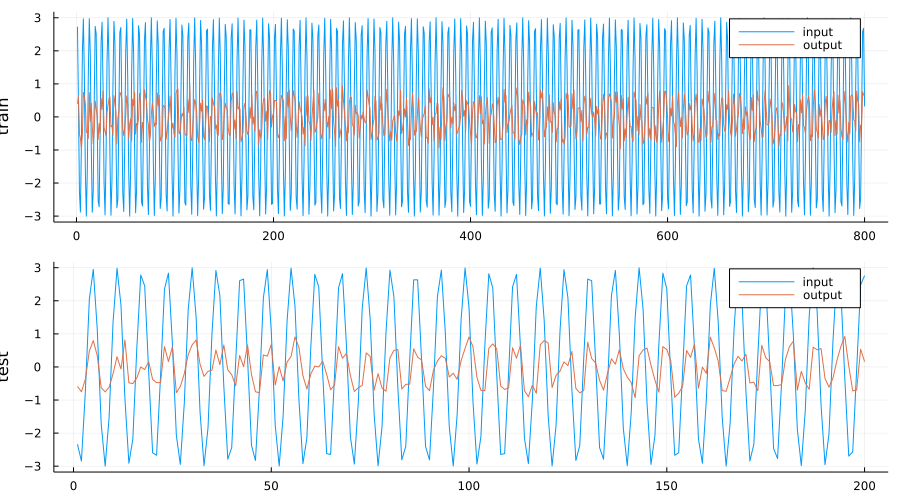

In [52]:
p101 = plot(reduce(hcat, U_train)[1,:], label="input", ylabel="train")
plot!(Y_train, label="output")
p102 = plot(reduce(hcat, U_test)[1,:], label="input", ylabel="test")
plot!(Y_test, label="output")
plot(p101, p102, layout=(2,1), size=(900,500))

In [58]:
matwrite("train_data.mat", Dict("u_trn" => reduce(hcat, U_train), "y_trn" => reshape(Y_train, (1,train_size))), compress = true)
matwrite("validation_data.mat", Dict("u_val" => reduce(hcat, U_test), "y_val" => reshape(Y_test, (1,n_samples-train_size))); compress = true)

---

In [18]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = [randn(flow_param_len); [0.1, 1.0]]

47-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644
  0.1
  1.0

In [19]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


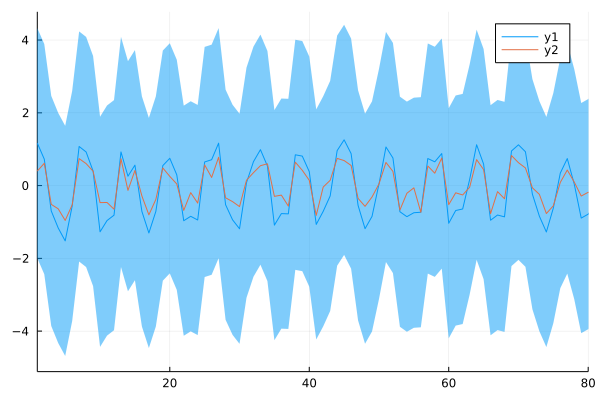

In [20]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

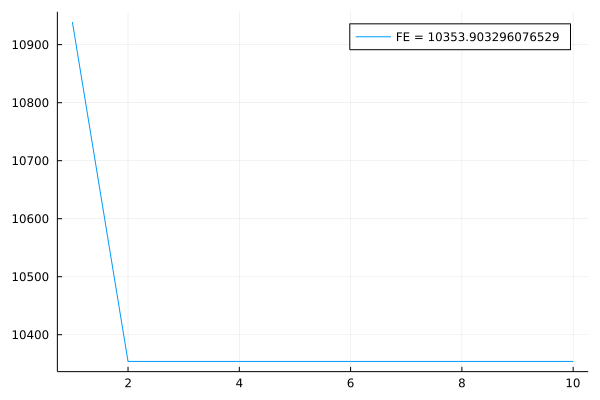

In [21]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [22]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, params,
                                                             y_order=order_y, u_order=order_u, h_order=order_h,
                                                             h_prior=(zeros(order_h), 0.1*diageye(order_h)), vmp_its=1)
    return fe[end]
end;

In [23]:
@time ForwardDiff.gradient(FE, model_params)

┌ Warning: #= /home/wmkouw/.julia/dev/ReactiveMP/src/algebra/helpers.jl:109 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ ReactiveMP /home/wmkouw/.julia/packages/LoopVectorization/kVenK/src/condense_loopset.jl:825


 24.825241 seconds (48.29 M allocations: 3.727 GiB, 7.21% gc time, 89.84% compilation time)


47-element Vector{Float64}:
     62.81014707590393
    -63.73175647857583
    -19.860061755657096
    -22.614827077179847
      1.8144346458342397
     22.417539209821
     13.914274870127201
     15.487869591946165
     40.05038229547857
   -238.01062750359213
    -40.21269983312061
    -38.26071038006171
   -102.16139983135201
      ⋮
    -25.474498701204027
    115.10477943742762
    165.77941316450597
     58.96320886067417
     -3.8622585643265666
    122.26261800372527
    -41.83364309653953
     27.197794745041683
    -19.97006435795894
    -25.438153180045106
 -74112.82950870844
     96.61901880742289

In [24]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_mv_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-13.9269, 0.214446, 0.28074, 0.519737, 2.13417, 0.704539, -0…

In [25]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [26]:
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-6, iterations = 500, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.093908e+04     7.411283e+04
 * time: 0.024980783462524414
     1     9.817723e+03     5.140638e+04
 * time: 15.308652877807617
     2     6.965021e+03     3.063251e+03
 * time: 24.047732830047607
     3     6.411381e+03     1.473544e+03
 * time: 32.16325783729553
     4     6.129011e+03     3.328566e+03
 * time: 38.697510957717896
     5     3.880626e+03     6.935591e+02
 * time: 51.988802909851074
     6     3.662189e+03     6.132552e+02
 * time: 56.83887791633606
     7     3.508325e+03     6.306581e+02
 * time: 61.45642399787903
     8     3.371764e+03     4.898195e+02
 * time: 66.0698299407959
     9     3.339283e+03     4.395046e+02
 * time: 72.91311287879944
    10     3.218035e+03     6.626185e+02
 * time: 79.54248595237732
    11     3.007178e+03     2.454244e+02
 * time: 90.15874099731445
    12     2.953539e+03     3.011076e+02
 * time: 97.43093180656433
    13     2.898077e+03     3.698503e+02
 * time: 103.25868391990662


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.931000e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.05e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.06e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.45e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-03 ≰ 0.0e+00
    |g(x)|                 = 3.98e+02 ≰ 1.0e-06

 * Work counters
    Seconds run:   625  (vs limit Inf)
    Iterations:    100
    f(x) calls:    267
    ∇f(x) calls:   267


In [27]:
inf_params = Optim.minimizer(res)


47-element Vector{Float64}:
 -2.826927948868731
  1.2845449429344264
 -0.8537482790576838
  0.4419967698074365
  0.6563295226544184
 -0.7930668649520154
  2.388051493387789
 -1.8389724052109
  1.6821696806657904
  5.955950516998053
 -0.6667104130441889
 -0.057901203357371
  1.4155828548138967
  ⋮
 -1.0966982195184856
 -1.313558687076352
 -1.1538116705536183
 -2.8470445890557703
 -0.2894147448354874
 -4.010089324995489
  0.8613244858796295
 -0.22794704360841847
  0.3567303877539073
 -0.431139439705591
  8.331867051907212
  4.7892196919729155

In [28]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params,
                                                                y_order=order_y, u_order=order_u, h_order=order_h,
                                                                h_prior=(zeros(order_h), 0.1*diageye(order_h)), vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [29]:
using JLD
JLD.save("../dump/flow_mv_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

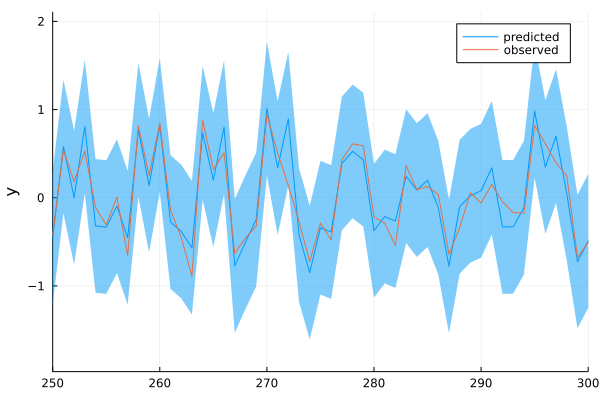

In [70]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)), label="predicted", ylabel="y")
plot!(Y_train, xlims=(250, 300), label="observed")

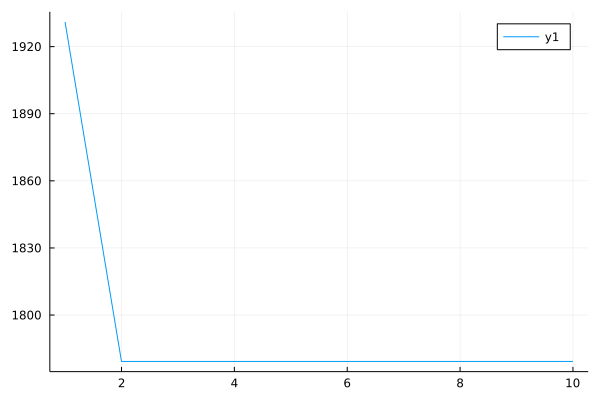

In [31]:
plot(fe_)

### KF-like prediction

In [32]:
function transition(γ, order)
#     V = zeros(order, order)
    V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [33]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, w, h_prior, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [34]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, w, h_prior,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [35]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [36]:
mx, vx = mean.(predictions), cov.(predictions);

In [37]:
test_from, test_to = 100, 150

(100, 150)

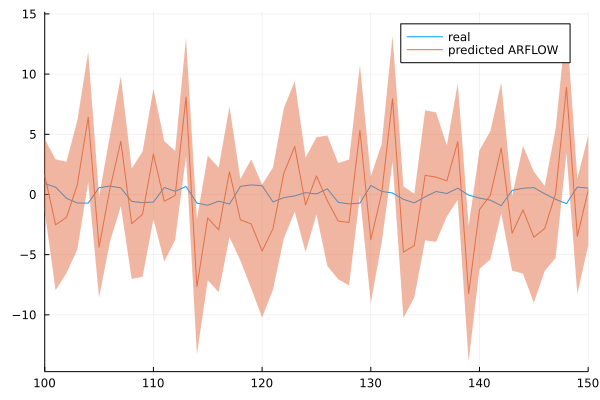

In [72]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted ARFLOW")

In [39]:
MSE_ARFLOW = mean((mx .- Y_test).^2)

13.365123267995022

In [65]:
baseline = matread("LSTMnet.mat")
MSE_LSTMnet = mean((baseline["predictions"] .- Y_test).^2)

┌ Warning: MATLAB SeriesNetwork values are currently not supported
└ @ MAT.MAT_HDF5 /home/wmkouw/.julia/packages/MAT/f523T/src/MAT_HDF5.jl:167


0.43051351453888054

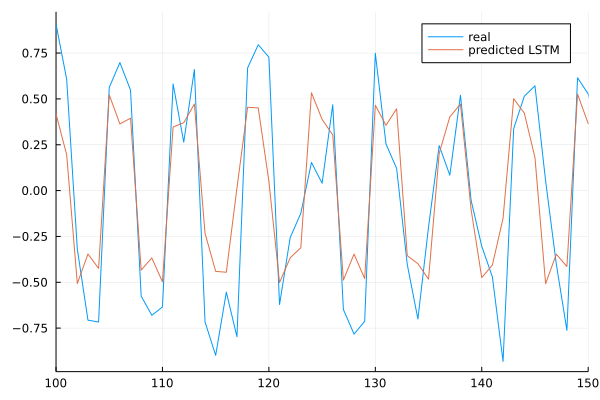

In [66]:
plot(Y_test, label="real")
plot!(baseline["predictions"]', xlims=(test_from, test_to), label="predicted LSTM")

In [42]:
# decrease noise
# increase sampling frequency